In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prettytable import PrettyTable


#### Paper: https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf

### Parameters:

In [2]:
s0 = 100 # initial mid-price

T = 1 # terminal time

sigma = 2 # volatility

dt = 0.005 # time step

N = 200

gamma = 0.1 # risk aversion parameter

k = 1.5 # k = alpha*K and this is determined by the market order size

A = 140 # scaling factor that depends on frequency  of market buy or sell orders and market order size

no_sim = 1000


In [3]:
# def r_a(s, q, t, sigma, gamma, T):
#     return s + (1 - 2 * q) * (gamma * sigma**2 * (T - t) / 2)

# def r_b(s, q, t, sigma, gamma, T):
#     return s + (-1 - 2 * q) * (gamma * sigma**2 * (T - t) / 2)

def res_price(s, q, t, sigma, gamma, T):
    return s - q * gamma * sigma**2 * (T - t)

def spread(t, k, sigma, gamma, T):
    return gamma * sigma**2 * (T - t) + 2 / gamma * np.log(1 + gamma / k)

def lambdaa(delta, A, k):
    return A * np.exp(-k * delta)

In [4]:
res_price(99.95425439061609, 0, 1, 2, 0.6497440, 3)
spread(0.005*2, 1.5, 2, 0.1, 1)

1.6867704227514233

### Simulate mid-price:

In [14]:
# Simulate geometric Brownian motion
s = np.zeros(N)
s[0] = s0
W = np.random.normal(0, np.sqrt(dt), N)
for i in range(1, N):
    ds = sigma * W[i-1]
    # print(ds)
    s[i] = s[i-1] + ds



[ 1.00000000e+002 -1.28697192e+001 -9.39967248e-001  8.72941586e-002
 -3.13309642e-003 -4.59507566e-004 -2.42635575e-005 -7.64381353e-007
 -9.93693684e-008  2.21683313e-008  1.26607512e-009 -4.44731654e-011
 -3.91269687e-012  9.74270928e-013 -6.86576246e-014 -1.74888284e-014
  1.88368950e-015 -6.05593788e-017  1.27613366e-017 -1.71891747e-018
  1.35826960e-019 -4.86380257e-021  6.65309530e-022 -1.15928890e-022
 -9.40397749e-024 -1.31155566e-024 -5.95609702e-026 -1.64504583e-027
  1.27898324e-029  1.90211007e-030 -1.51577286e-031 -1.54759236e-032
 -2.70802311e-033 -5.23812637e-034 -1.62534448e-034 -6.89132171e-036
 -1.73104732e-036  1.89941949e-037  9.47990793e-039 -1.05805051e-039
 -9.48956086e-041  5.53015876e-042  5.42593639e-043 -8.58415677e-044
 -3.23447414e-044  2.19646790e-045  1.04099621e-046  1.18217931e-047
  1.09869300e-048 -2.51426939e-051  2.27655097e-052 -1.35894439e-053
 -1.23405212e-054 -1.48432994e-055  1.49923926e-056  6.25600565e-058
  7.83117041e-059  4.58245972e-060

### Benchmark strategy:

In [6]:
spread_simulations = [] 
profits_benchmark = []
final_inventories_benchmark = []
final_cash_benchmark = []

for j in range(no_sim):

    q_benchmark = np.zeros(N) # inventory
    spread_array_benchmark = np.zeros(N)
    x_benchmark = np.zeros(N) # wealth

    Bid_benchmark = np.zeros(N)
    delta_b = np.zeros(N)
    prob_b = np.zeros(N)

    Ask_benchmark = np.zeros(N) 
    delta_a = np.zeros(N)
    prob_a = np.zeros(N)

    # Generate Brownian motion
    t = np.linspace(0.0, T, N)
    # np.random.seed(44)
    # W = np.random.normal(0, np.sqrt(dt), N)


    spread_array_benchmark[0] = spread(t[0], k, sigma, gamma, T)

    Bid_benchmark[0] = s[0] - spread_array_benchmark[0]/2
    Ask_benchmark[0] = s[0] + spread_array_benchmark[0]/2

    delta_b[0] = spread_array_benchmark[0]/2
    delta_a[0] = spread_array_benchmark[0]/2

    prob_b[0] = lambdaa(delta_b[0], A, k)
    prob_a[0] = lambdaa(delta_a[0], A, k)


    for i in range(1, N):
        spread_array_benchmark[i] = spread(t[i], k, sigma, gamma, T)

        Bid_benchmark[i] = s[i] - spread_array_benchmark[i]/2
        Ask_benchmark[i] = s[i] + spread_array_benchmark[i]/2

        delta_b[i] = spread_array_benchmark[i]/2
        delta_a[i] = spread_array_benchmark[i]/2

        prob_b[i] = lambdaa(delta_b[i], A, k)*dt
        prob_a[i] = lambdaa(delta_a[i], A, k)*dt

        rand_b = random.random()
        rand_a = random.random()

        # we execute sell order only
        if (rand_b <= prob_b[i] and rand_a > prob_a[i]):
            q_benchmark[i] = q_benchmark[i-1] + 1
            x_benchmark[i] = x_benchmark[i-1] - Bid_benchmark[i]

        # we execute buy order only
        elif rand_b > prob_b[i] and rand_a <= prob_a[i]:
            q_benchmark[i] = q_benchmark[i-1] - 1
            x_benchmark[i] = x_benchmark[i-1] + Ask_benchmark[i]
            
        # we execute both sell and buy orders
        elif rand_b <= prob_b[i] and rand_a <= prob_a[i]:
            q_benchmark[i] = q_benchmark[i-1]
            x_benchmark[i] = x_benchmark[i-1] + Ask_benchmark[i] - Bid_benchmark[i]
            
        # we dont execute any
        else:
            q_benchmark[i] = q_benchmark[i-1]
            x_benchmark[i] = x_benchmark[i-1]

    profits_benchmark.append(x_benchmark[-1] + q_benchmark[-1]*s[-1])
    final_inventories_benchmark.append(q_benchmark[-1])
    final_cash_benchmark.append(x_benchmark[-1])



### Inventory strategy:

In [7]:
spread_simulations = [] 
profits = []
final_inventories = []
final_cash = []

for j in range(no_sim):

    q = np.zeros(N) # inventory
    res_price_array = np.zeros(N)
    spread_array = np.zeros(N)
    x = np.zeros(N) # wealth

    Bid_price = np.zeros(N)
    delta_b = np.zeros(N)
    prob_b = np.zeros(N)

    Ask_price = np.zeros(N) 
    delta_a = np.zeros(N)
    prob_a = np.zeros(N)

    # Generate Brownian motion
    t = np.linspace(0.0, T, N)
    # np.random.seed(44)
    W = np.random.normal(0, np.sqrt(dt), N)


    res_price_array[0] = res_price(s[0], q[0], t[0], sigma, gamma, T)
    spread_array[0] = spread(t[0], k, sigma, gamma, T)

    Bid_price[0] = res_price_array[0] - spread_array[0]/2
    Ask_price[0] = res_price_array[0] + spread_array[0]/2

    delta_b[0] = s[0] - Bid_price[0]
    delta_a[0] = Ask_price[0] - s[0]

    prob_b[0] = lambdaa(delta_b[0], A, k)
    prob_a[0] = lambdaa(delta_a[0], A, k)


    for i in range(1, N):
        res_price_array[i] = res_price(s[i], q[i-1], t[i], sigma, gamma, T)
        spread_array[i] = spread(t[i], k, sigma, gamma, T)

        Bid_price[i] = res_price_array[i] - spread_array[i]/2
        Ask_price[i] = res_price_array[i] + spread_array[i]/2

        delta_b[i] = s[i] - Bid_price[i]
        delta_a[i] = Ask_price[i] - s[i]

        prob_b[i] = lambdaa(delta_b[i], A, k)*dt
        prob_a[i] = lambdaa(delta_a[i], A, k)*dt

        rand_b = random.random()
        rand_a = random.random()

        # we execute sell order only
        if (rand_b <= prob_b[i] and rand_a > prob_a[i]):
            q[i] = q[i-1] + 1
            x[i] = x[i-1] - Bid_price[i]

        # we execute buy order only
        elif rand_b > prob_b[i] and rand_a <= prob_a[i]:
            q[i] = q[i-1] - 1
            x[i] = x[i-1] + Ask_price[i]
            
        # we execute both sell and buy orders
        elif rand_b <= prob_b[i] and rand_a <= prob_a[i]:
            q[i] = q[i-1]
            x[i] = x[i-1] + Ask_price[i] - Bid_price[i]
            
        # we dont execute any
        else:
            q[i] = q[i-1]
            x[i] = x[i-1]

    spread_simulations.append(np.mean(spread_array)) 
    profits.append(x[-1] + q[-1]*s[-1])
    final_inventories.append(q[-1])
    final_cash.append(x[-1])



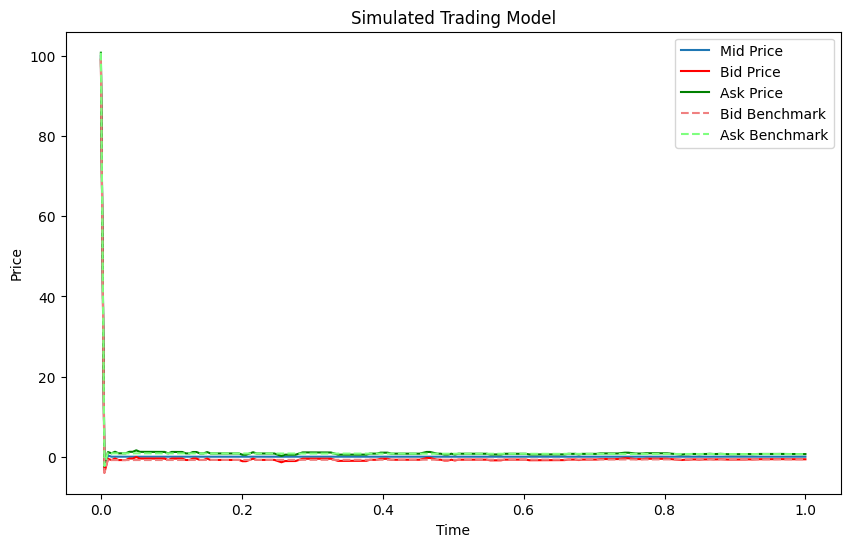

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t, s, label='Mid Price')
# plt.plot(t, res_price_array, label='Res Price')

plt.plot(t, Bid_price, label='Bid Price', color='red', linestyle='-')
plt.plot(t, Ask_price, label='Ask Price', color='green', linestyle='-')
plt.plot(t, Bid_benchmark, label='Bid Benchmark', color='lightcoral', linestyle='--')
plt.plot(t, Ask_benchmark, label='Ask Benchmark', color='#7FFF7F', linestyle='--')

plt.title('Simulated Trading Model')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

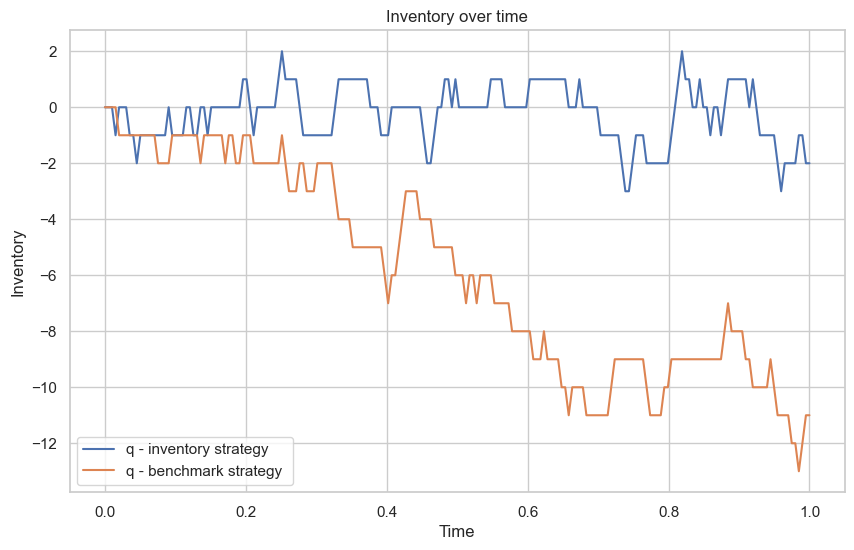

In [9]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
plt.plot(t, q, label='q - inventory strategy')
plt.plot(t, q_benchmark, label='q - benchmark strategy ')

plt.title('Inventory over time')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.legend()
plt.show()

In [10]:
print("1000 simulations for gamma = ", gamma)
table = PrettyTable()
table.field_names = ["Strategy", "Average Spread", "Average Profit", "Std (Profit)", "Final q", "Std (Final q)"]
table.add_row(["Inventory", np.mean(spread_simulations), np.mean(profits), np.std(profits), np.mean(final_inventories), np.std(final_inventories)])
table.add_row(["Benchmark", np.mean(spread_simulations), np.mean(profits_benchmark), np.std(profits_benchmark), np.mean(final_inventories_benchmark), np.std(final_inventories_benchmark)])
print(table)


np.std(spread_simulations)

# table.field_names = ["Strategy", "Average Spread", "Average Profit", "Std (Profit)", "Average Final Cash", "Std (Final Cash)","Final q", "Std (Final q)"]
# table.add_row(["Inventory", np.mean(spread_simulations), np.mean(profits), np.std(profits), np.mean(final_cash), np.std(final_cash),np.mean(final_inventories), np.std(final_inventories)])
# table.add_row(["Benchmark", np.mean(spread_simulations), np.mean(profits_benchmark), np.std(profits_benchmark), np.mean(final_cash_benchmark), np.std(final_cash_benchmark), np.mean(final_inventories_benchmark), np.std(final_inventories_benchmark)])
# print(table)

1000 simulations for gamma =  0.1
+-----------+--------------------+-------------------+-------------------+---------+-------------------+
|  Strategy |   Average Spread   |   Average Profit  |    Std (Profit)   | Final q |   Std (Final q)   |
+-----------+--------------------+-------------------+-------------------+---------+-------------------+
| Inventory | 1.4907704227514236 | 64.72648769663488 | 6.113944246785376 |  -0.029 | 2.934988756366879 |
| Benchmark | 1.4907704227514236 | 67.44512633678698 | 6.358692388029446 |  0.114  | 8.340923450074339 |
+-----------+--------------------+-------------------+-------------------+---------+-------------------+


2.220446049250313e-16

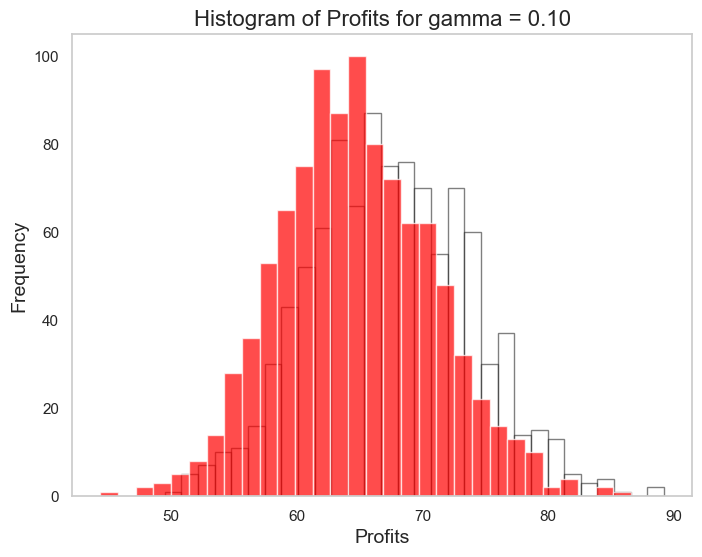

In [11]:
# Set seaborn style
sns.set(style='whitegrid')
# Plot the histogram with styling
plt.figure(figsize=(8, 6))
plt.hist(profits_benchmark, bins=30, color='white', alpha=0.5, edgecolor='black')
plt.hist(profits, bins=30, color='red', edgecolor='white', alpha=0.7)
plt.title('Histogram of Profits for gamma = {:.2f}'.format(gamma),fontsize=16)
plt.xlabel('Profits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Remove grid
plt.grid(False)

plt.show()


In [12]:
import random 
random.random()

0.695866979190146